In [1]:
%matplotlib inline
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astropy.timeseries import LombScargle
from astropy.coordinates import SkyCoord,ICRS, Galactic
from astropy.table import Table


import pyvo as vo

from astropy.table import Table

import requests
import astropy
import time

from IPython.display import display
from IPython.core.display import HTML

import warnings
warnings.filterwarnings("ignore", module="astropy.io.votable.*")
warnings.filterwarnings("ignore", module="pyvo.utils.xml.elements")
warnings.filterwarnings("ignore", module="pyvo.io.vosi.vodataservice")

In [2]:
%%html
<style>
.output_wrapper .output {
  overflow-y: visible;
  height: fit-content;
}
</style>
table.Conf(default_notebook_table_class)

In [3]:
def display_images(images,names):
    num_images = len(images)
    num_rows = int(np.sqrt(num_images))
    num_cols = int(np.ceil(num_images / num_rows))
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
    axes = axes.flatten()

    for i in range(num_images):
        axes[i].imshow(images[i])
        axes[i].set_xlabel(names[i])
        axes[i].tick_params(labelleft=None,labelbottom=None,left=None,bottom=None)
        #axes[i].axis('off')

    # Remove any empty subplots
    if num_images < len(axes):
        for j in range(num_images, len(axes)):
            fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def display_plot(X,Y,names):
    num_images = len(X)
    num_rows = int(np.sqrt(num_images))
    num_cols = int(np.ceil(num_images / num_rows))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
    axes = axes.flatten()

    for i in range(num_images):
        axes[i].plot(X[i],Y[i])
        axes[i].set_xlabel(names[i])
        axes[i].tick_params(labelleft=None,left=None)
        axes[i].set_xscale('log')
        #axes[i].axis('off')

    # Remove any empty subplots
    if num_images < len(axes):
        for j in range(num_images, len(axes)):
            fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
def Fold(time,period):
    time=time[~ np.isnan(time)]
    t0=np.nanmin(time)
    return(((time - t0) / period )- ([(int((x - t0)/ period)) for x in time])) #phase


def megazord(time, pdc_flux, sap_flux, flags, power, frequency,phase, image, name):
    fig = plt.figure(figsize=(10, 6))
    gs = fig.add_gridspec(3, 3)

    ax1 = fig.add_subplot(gs[0, 0:2]) #SAP Flux
    print(len(time),len(sap_flux))
    ax1.scatter(time, sap_flux, s=0.01, c='blue')
    ax1.scatter(time[flags > 0], sap_flux[flags > 0], s=1, c='red')
    ax1.set_title("SAP Flux")
    ax1.set_xlabel("Time (mjd)")

    ax2 = fig.add_subplot(gs[1, 0:2]) #PDC Flux

    ax2.scatter(time, pdc_flux, s=0.01, c='blue')
    ax2.scatter(time[flags > 0], pdc_flux[flags > 0], s=1, c='red')
    ax2.set_title("PDCSAP Flux")
    ax2.set_xlabel("Time (mjd)")

    ax3 = fig.add_subplot(gs[2, 0:1]) #Lomb Scargle Periodogram
    period=1/frequency
    ax3.set_title("Lomb-Scargle periodogram")
    ax3.plot(period, power) 
    ax3.set_xscale('log')
    ax3.set_xlabel(f"Peak at {round(period[power==np.max(power)][0],2)} day")

    ax4 = fig.add_subplot(gs[2, 1:2]) #Phase diagram
    ax4.set_title("Phase folded")
    ax4.scatter(phase,pdc_flux[~np.isnan(time)],s=0.01)
    ax4.tick_params(labelleft=None,left=None)
    ax4.set_xlabel("Overlapped period")

    ax5 = fig.add_subplot(gs[0, -1])
    ax5.imshow(image, origin="lower")

    fig.suptitle(name)
    plt.tight_layout()
def megazord2(table):
    print(len(table["Time"]),len(table["PDC_F"]),len(table["SAP_F"]))
    megazord(table["Time"], table["PDC_F"], table["SAP_F"], table["Flag"], table["Power"], table["Frequency"],table["Phase"], table["Image"], table["ID"])
'''
sub=table[1]
megazord(sub["Time"], sub["PDC_F"], sub["Flag"], sub["Power"], sub["Frequency"],sub["Phase"], sub["Image"], sub["ID"])
'''


'\nsub=table[1]\nmegazord(sub["Time"], sub["PDC_F"], sub["Flag"], sub["Power"], sub["Frequency"],sub["Phase"], sub["Image"], sub["ID"])\n'

In [4]:
file="./Tables/cross_TESS.csv" #Table des crossmatch
cross_TESS= Table.read(file,format='csv')
display(cross_TESS[:1])
URL=cross_TESS["access_url"]

angDist,recno,Source_1,4XMM,RA_ICRS,DE_ICRS,ePos,srcML,Flux1,e_Flux1,Flux2,e_Flux2,Flux3,e_Flux3,Flux4,e_Flux4,Flux5,e_Flux5,Flux8,e_Flux8,Flux9,e_Flux9,HR1,e_HR1,HR2,e_HR2,HR3,e_HR3,HR4,e_HR4,ext,e_ext,extML,Cst,Fvar,e_Fvar,V,S,F8min,e_F8min,F8max,e_F8max,MJD0,MJD1,Nd,c,uIRAP,xcatDB,IRAP,glon,glat,DR3Name,RAdeg,DEdeg,errHalfMaj,errHalfMin,errPosAng,SolID,Source_2,RandomI,e_RAdeg,e_DEdeg,Plx,e_Plx,RPlx,PM,pmRA,e_pmRA,pmDE,e_pmDE,RADEcor,RAPlxcor,RApmRAcor,RApmDEcor,DEPlxcor,DEpmRAcor,DEpmDEcor,PlxpmRAcor,PlxpmDEcor,pmRApmDEcor,NAL,NAC,NgAL,NbAL,gofAL,chi2AL,epsi,sepsi,Solved,APF,nueff,pscol,e_pscol,RApscolCorr,DEpscolCorr,PlxpscolCorr,pmRApscolCorr,pmDEpscolCorr,MatchObsA,Nper,amax,MatchObs,IPDgofha,IPDgofhp,IPDfmp,IPDfow,RUWE,Dup,o_Gmag,FG,e_FG,RFG,Gmag,e_Gmag,o_BPmag,FBP,e_FBP,RFBP,BPmag,e_BPmag,o_RPmag,FRP,e_FRP,RFRP,RPmag,e_RPmag,E(BP/RP),NBPcont,NBPblend,NRPcont,NRPblend,Mode,BP-RP,BP-G,G-RP,RV,e_RV,n_RV,o_RV,o_RVd,RVNper,RVS/N,RVgof,RVchi2,RVTdur,RVamp,RVtempTeff,RVtemplogg,RVtemp[Fe/H],Vatmparam,vbroad,e_Vbroad,o_Vbroad,GRVSmag,e_GRVSmag,o_GRVSmag,RVSS/N,VarFlag,PQSO,PGal,PSS,Teff,b_Teff_1,B_Teff_1a,logg,b_logg_1,B_logg_1a,[Fe/H],b_[Fe/H]_1,B_[Fe/H]_1a,Dist,b_Dist_1,B_Dist_1a,A0,b_A0_1,B_A0_1a,AG,b_AG_1,B_AG_1a,E(BP-RP),b_E(BP-RP)_1,B_E(BP-RP)_1a,Lib,RAJ2000,DEJ2000,e_RAJ2000,e_DEJ2000,RADEcorJ2000,Distance,Gabs,Gabs_corrected,Color_corrected,Flux_8_Avg,Flux_8_Avg_err,Flux_6_Avg,Flux_7_Avg,6_RATE_Avg,7_RATE_Avg,L_6_Avg,L_7_Avg,L_8_Avg,HR,dataproduct_type,calib_level,obs_collection,obs_id,obs_publisher_did,access_url,access_format,access_estsize,target_name,s_ra,s_dec,s_fov,s_region,s_xel1,s_xel2,s_resolution,t_min,t_max,t_exptime,t_resolution,t_xel,em_min,em_max,em_res_power,em_xel,o_ucd,pol_states,pol_xel,facility_name,instrument_name,GroupID,GroupSize,Separation
float64,int64,int64,str16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,int64,int64,str54,str6,str4,float64,float64,str28,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,int64,float64,float64,int64,int64,float64,int64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,str13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str10,int64,str4,str52,str81,str126,str16,int64,int64,float64,float64,int64,str46,int64,int64,int64,float64,float64,float64,int64,int64,float64,float64,int64,int64,int64,int64,int64,str9,str10,int64,int64,float64
1.025314,154379,200495603010007,J053531.1-042151,83.879651,-4.364281,0.326311,5094.4,8.1967e-14,7.7953e-15,2.6094e-13,1.1475e-14,2.6736e-13,1.0344e-14,1.65e-13,1.374e-14,4.4722e-14,2.7887e-14,8.3409e-13,3.7341e-14,8.1001e-13,2.235e-14,0.63224,0.031243,0.130734,0.028744,-0.604939,0.0291,-0.87191,0.063904,0.0,--,0.32666,0.439235,0.054576,0.249602,0,0,8.3409e-13,3.7341e-14,8.3409e-13,3.7341e-14,52532.3161,52532.4957,1,0,http://xmm-catalog.irap.omp.eu/source/2

In [5]:
P_tot, Images, names, frequency_list, power_list, time_list, pdc_flux_list, flags, sap_flux_list,phase_list=[],[],[],[],[],[],[],[],[],[]
for i,url in enumerate(cross_TESS["access_url"]):
    with fits.open(url, mode="readonly") as hdulist: #Pk pas tout stocker dans une variable au lieu de "WITH"?
        time = hdulist[1].data['TIME'] #Timestamp
        pdc_flux = hdulist[1].data['PDCSAP_FLUX'] #Best estimated flux
        sap_flux=hdulist[1].data['SAP_FLUX'] 
        qual_flags=hdulist[1].data['QUALITY']
        aperture = hdulist[2].data
    mask=(np.isnan(time)) | (np.isnan(pdc_flux)) 
    frequency,power = LombScargle(time[~mask], pdc_flux[~mask]).autopower()
    frequency,power = frequency[frequency<1e2],power[frequency<1e2]
    period=1 / frequency
    
    period_computed=period[power==np.max(power)][0]
    P_tot.append(period_computed)
    Images.append(aperture)
    names.append(str(cross_TESS["target_name"][i])+" "+str(cross_TESS["s_ra"][i]) + " " + str(cross_TESS["s_dec"][i]))
    frequency_list.append(frequency)
    power_list.append(power)
    time_list.append(time)
    pdc_flux_list.append(pdc_flux)
    flags.append(qual_flags)
    sap_flux_list.append(sap_flux)
    

    phase=Fold(time,period_computed)
    phase_list.append(phase)
try:
    cross_TESS.add_column(P_tot, name='Period(d)')
    #cross_TESS.add_column(Images, name="Aperture")
except:
    cross_TESS.replace_column("Period(d)", P_tot)
    #cross_TESS.replace_column("Aperture", Images)

In [10]:
# temp_time=time[~ np.isnan(time)]
# t0=np.nanmin(time)
# phase=((temp_time - t0) / period_computed )- [(int((x - t0)/ period_computed)) for x in temp_time]

In [7]:
table=Table([cross_TESS["target_name"],P_tot,frequency_list,power_list,time_list
            ,pdc_flux_list,sap_flux_list,phase_list,flags,Images]
            ,names=("ID","Period","Frequency","Power","Time","PDC_F","SAP_F","Phase","Flag","Image")) 

In [8]:
#display(table[:1])
print(table.colnames)

['ID', 'Period', 'Frequency', 'Power', 'Time', 'PDC_F', 'SAP_F', 'Phase', 'Flag', 'Image']


15678 15678


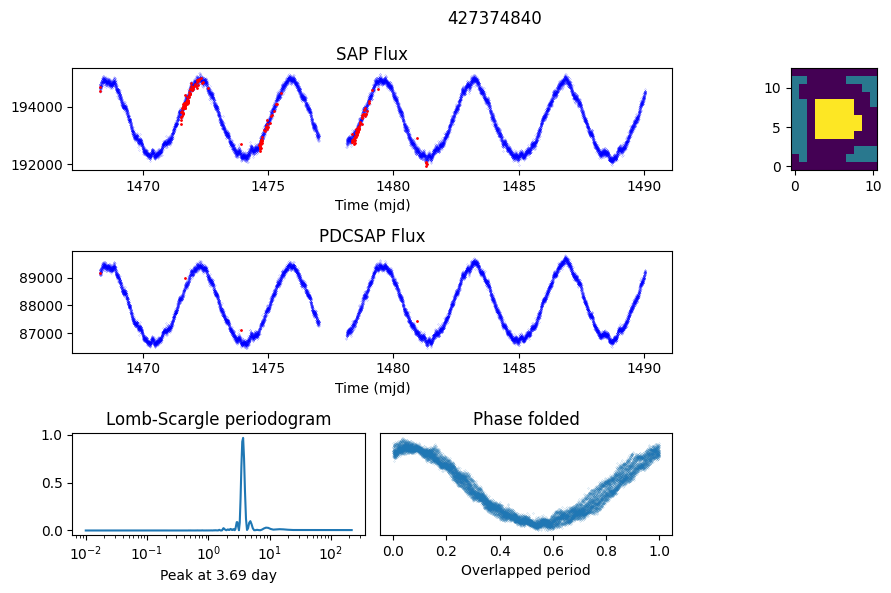

In [11]:
megazord(table["Time"][1], table["PDC_F"][1],table["SAP_F"][1]
         , table["Flag"][1], table["Power"][1], table["Frequency"][1]
         ,table["Phase"][1], table["Image"][1], table["ID"][1])
plt.tight_layout()
plt.savefig("./Images/Tess.pdf")

18730 18730


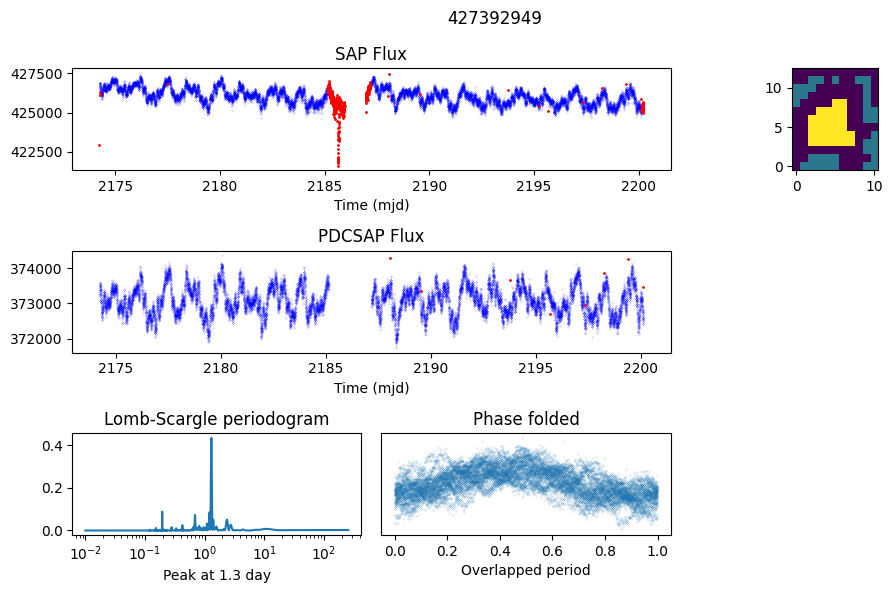

15678 15678


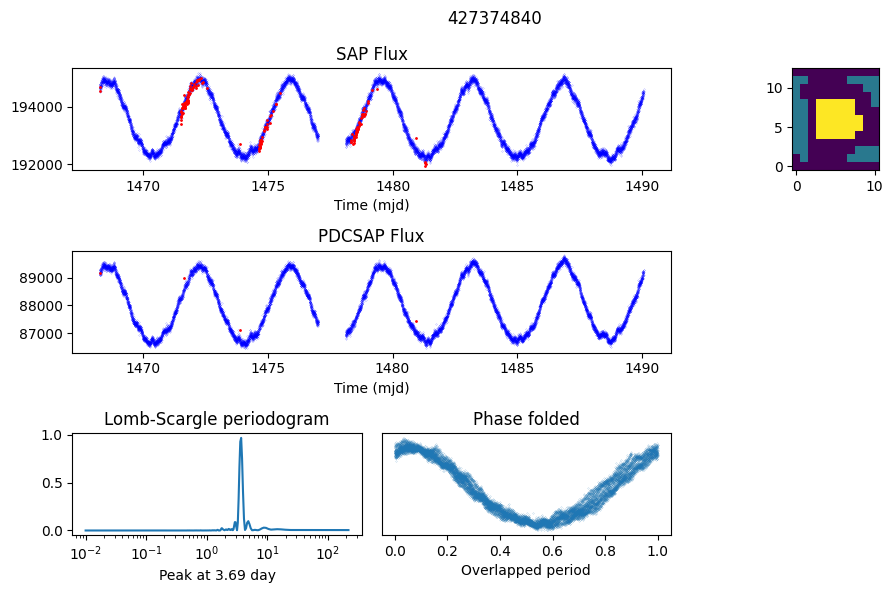

18730 18730


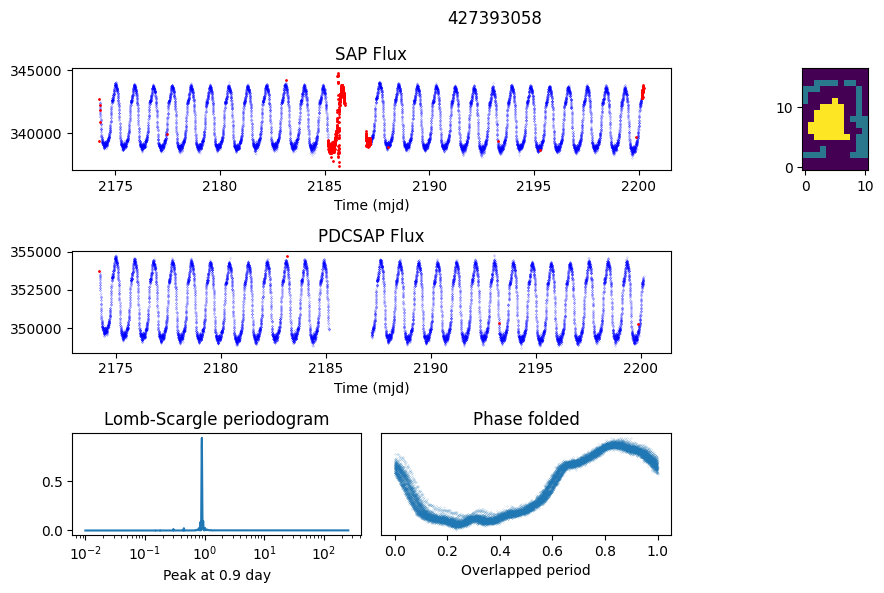

15678 15678


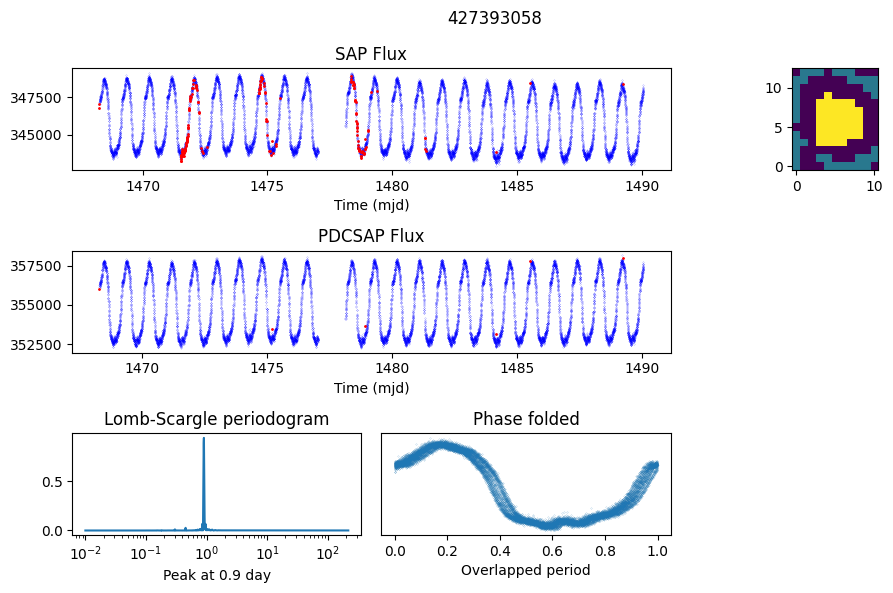

18730 18730


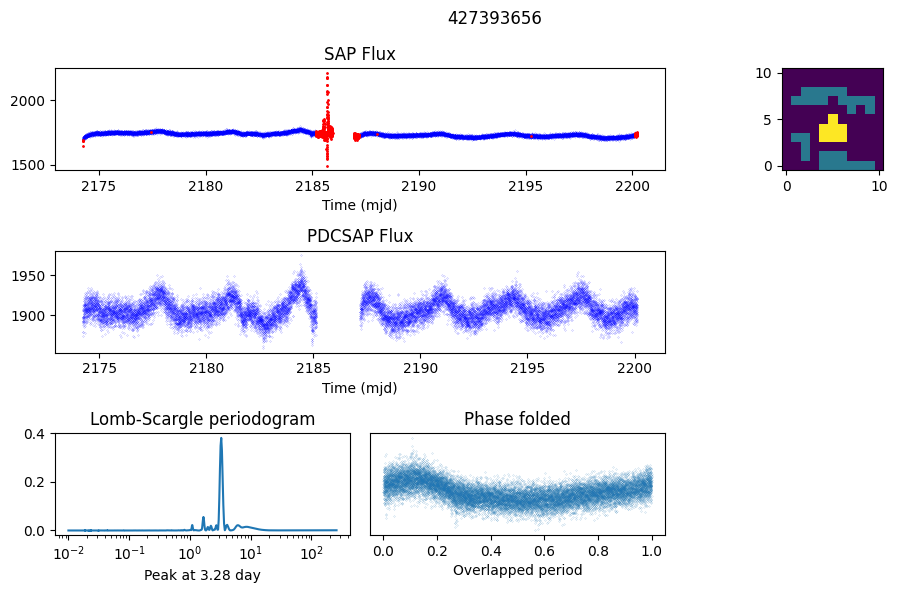

18730 18730


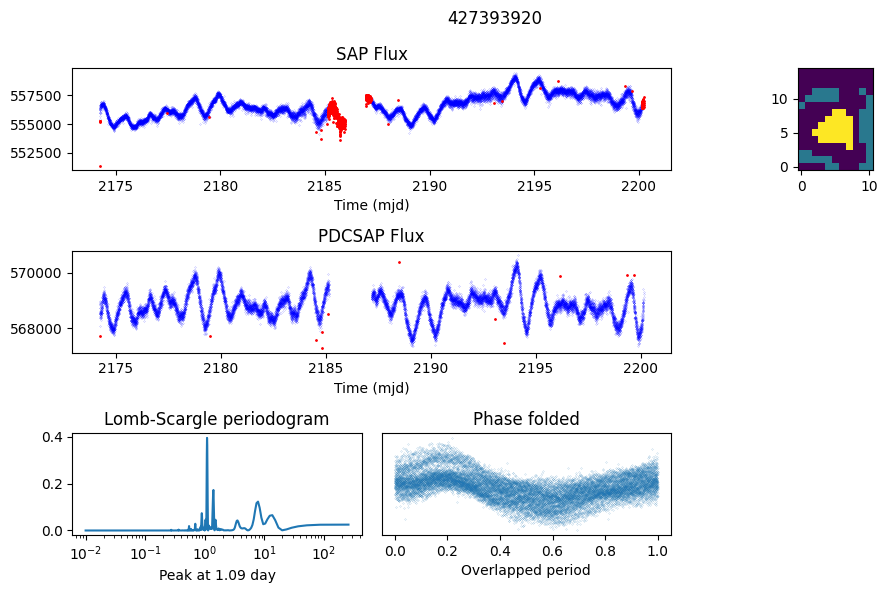

15678 15678


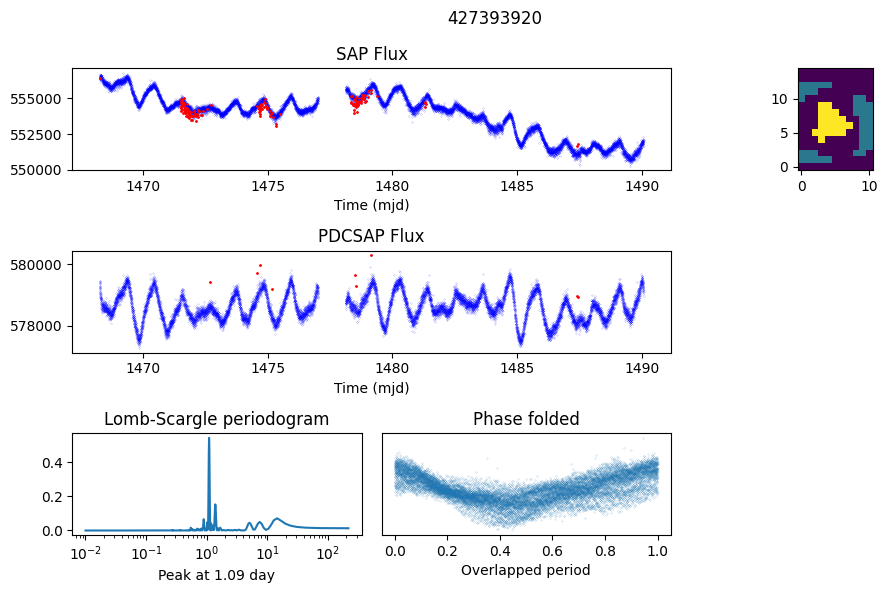

18730 18730


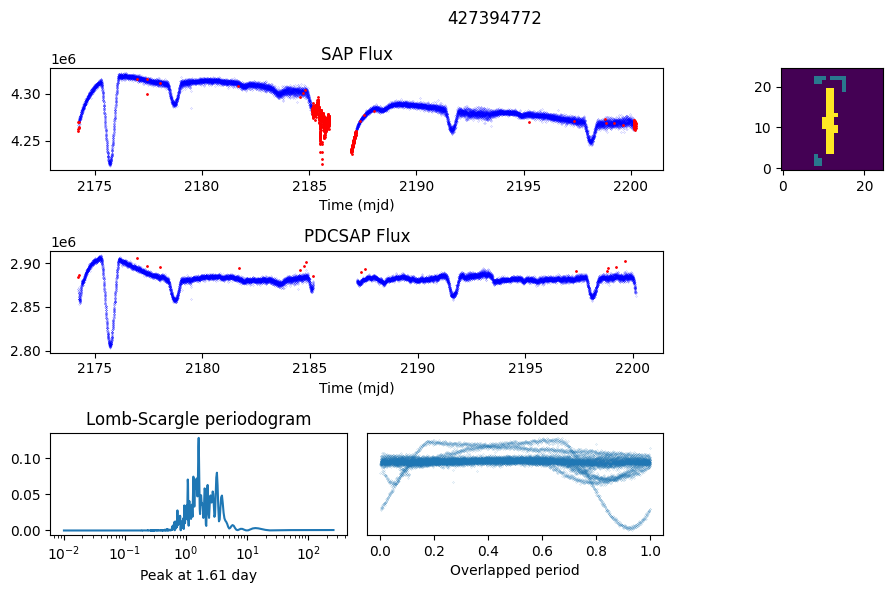

15678 15678


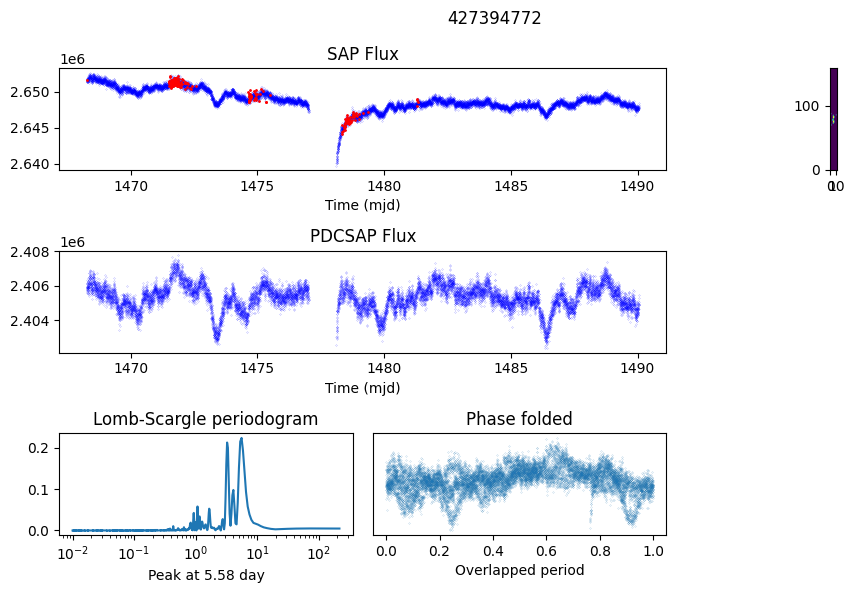

15678 15678


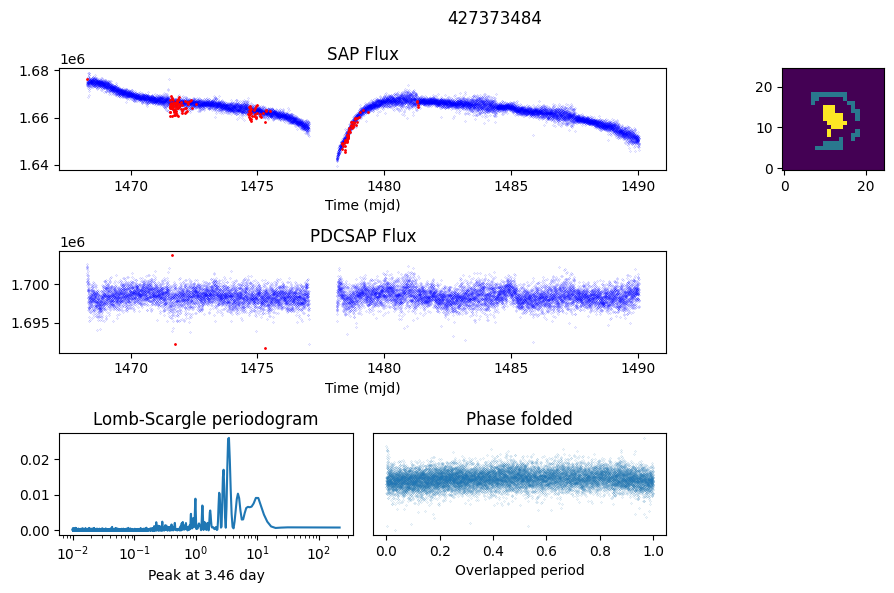

18730 18730


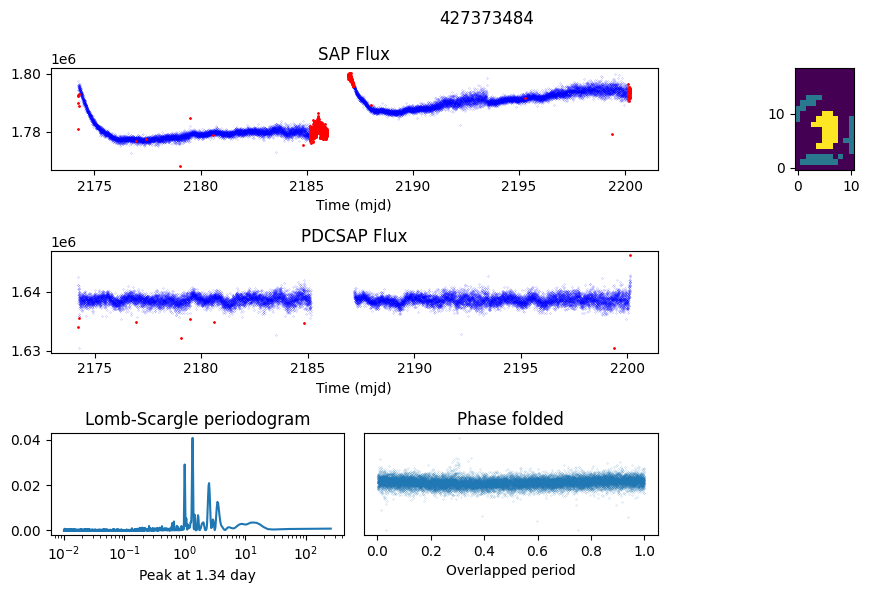

15678 15678


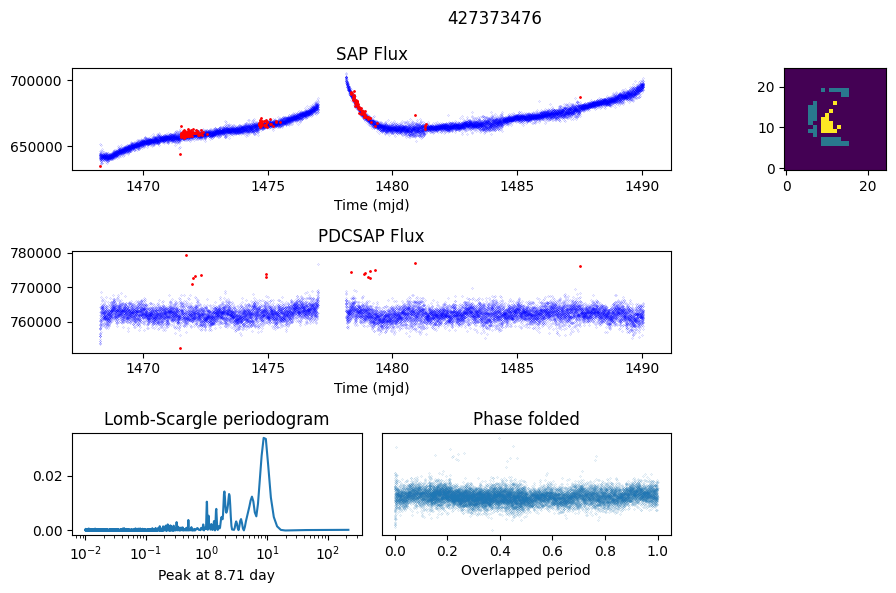

18730 18730


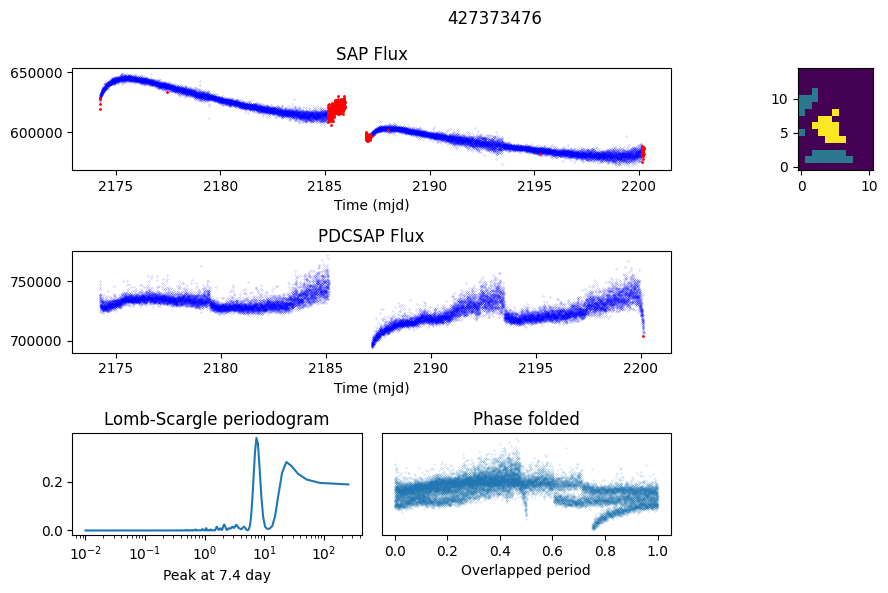

18730 18730


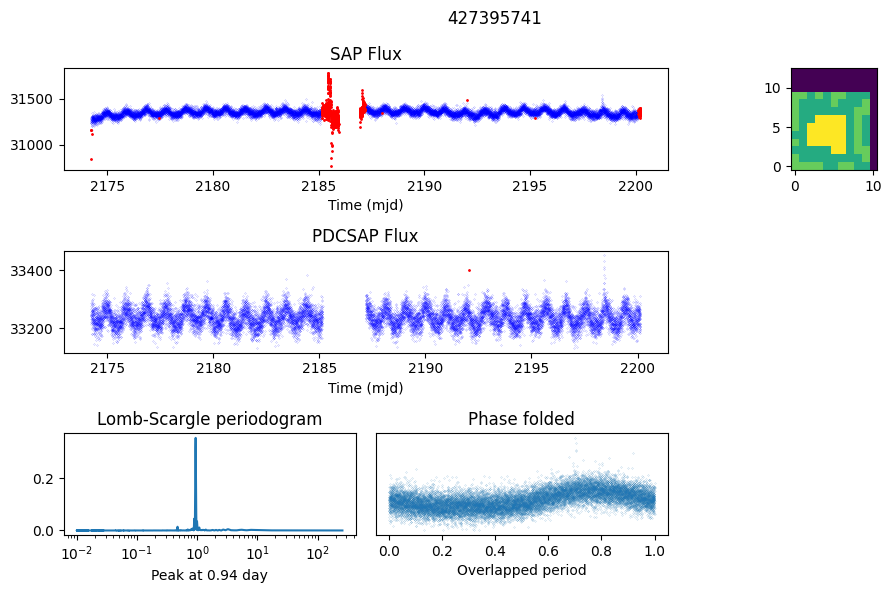

112388 112388


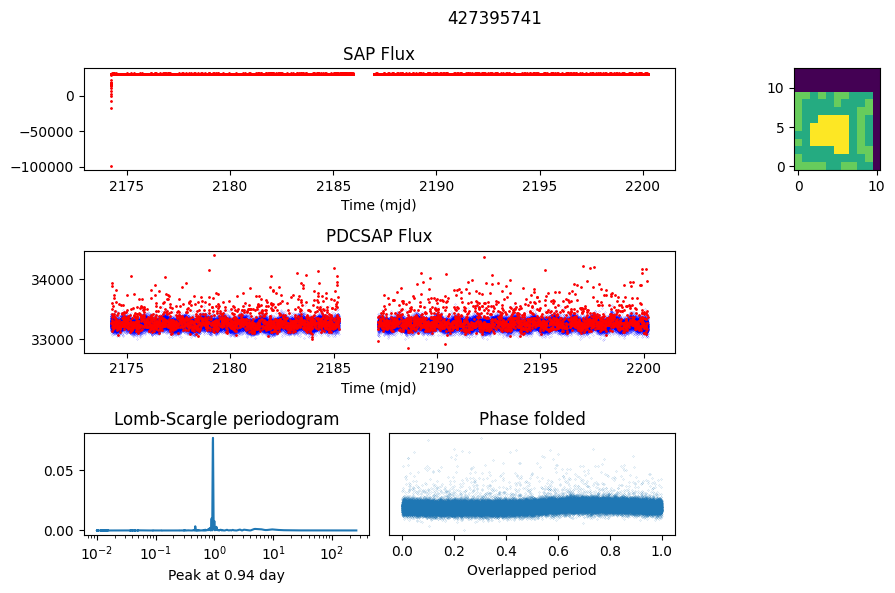

15678 15678


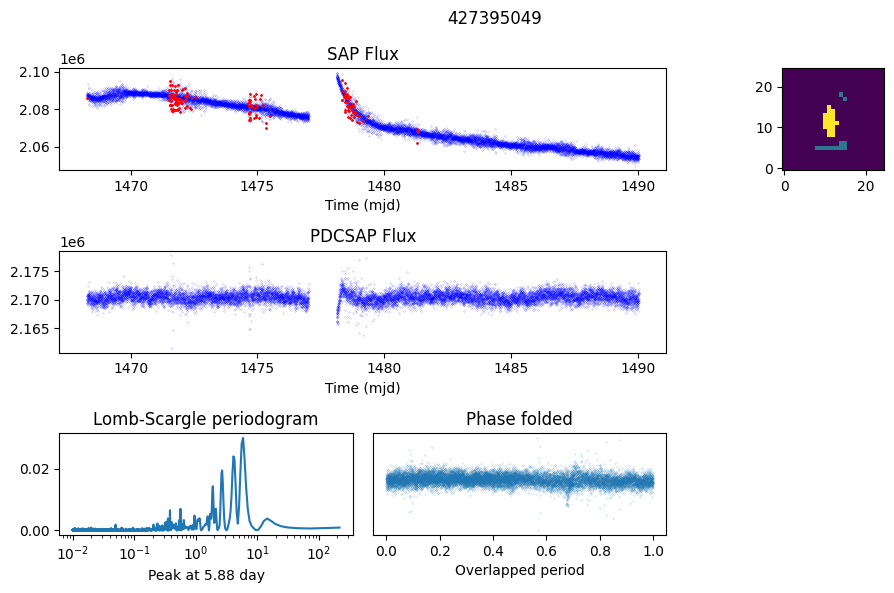

18730 18730


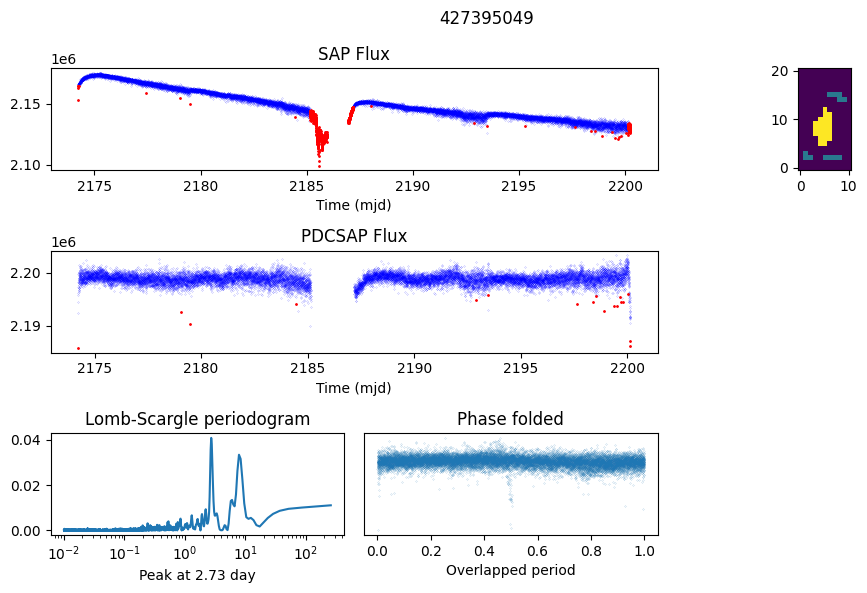

15678 15678


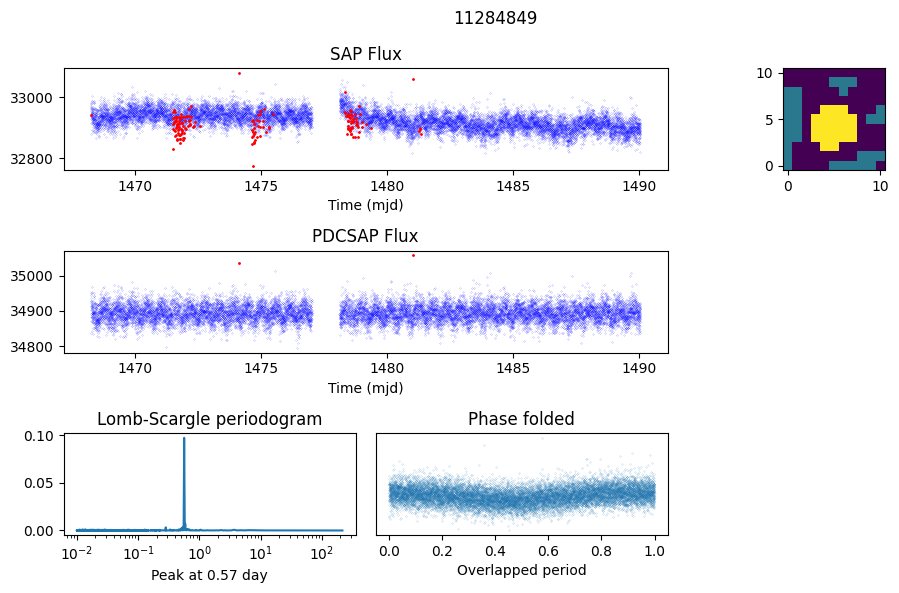

15678 15678


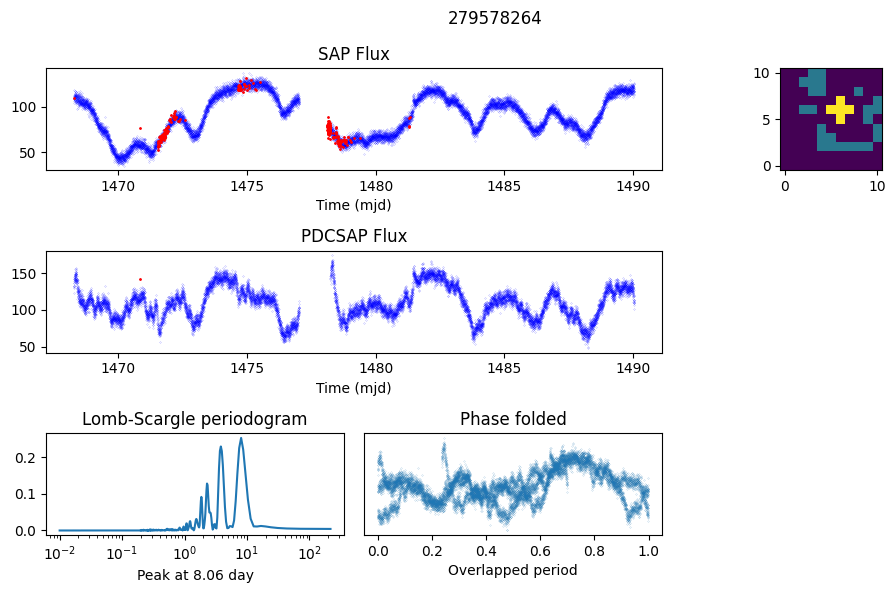

15678 15678


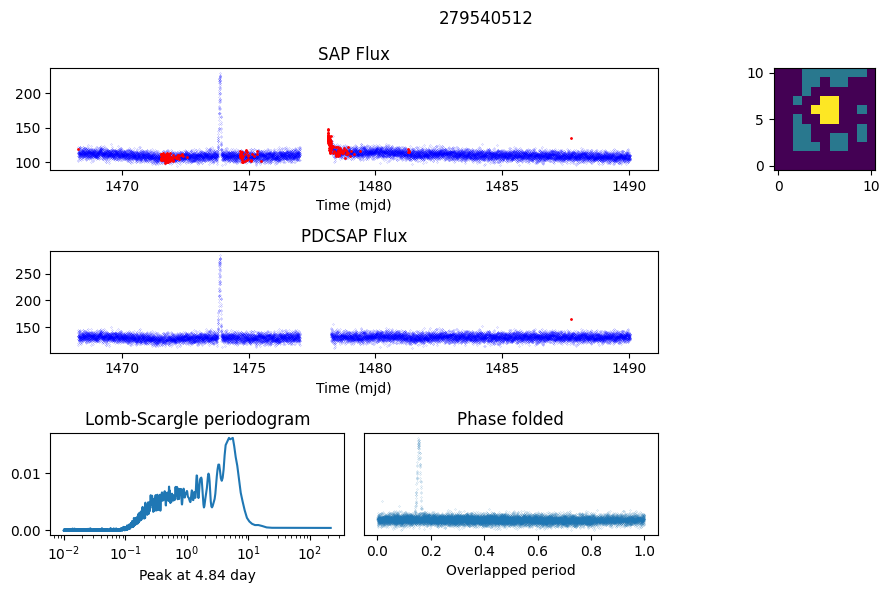

15678 15678


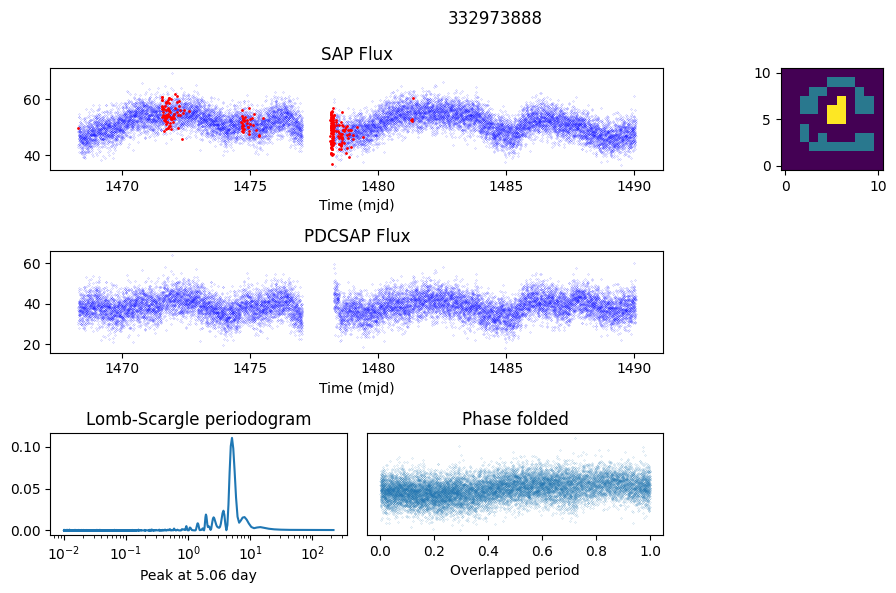

18730 18730


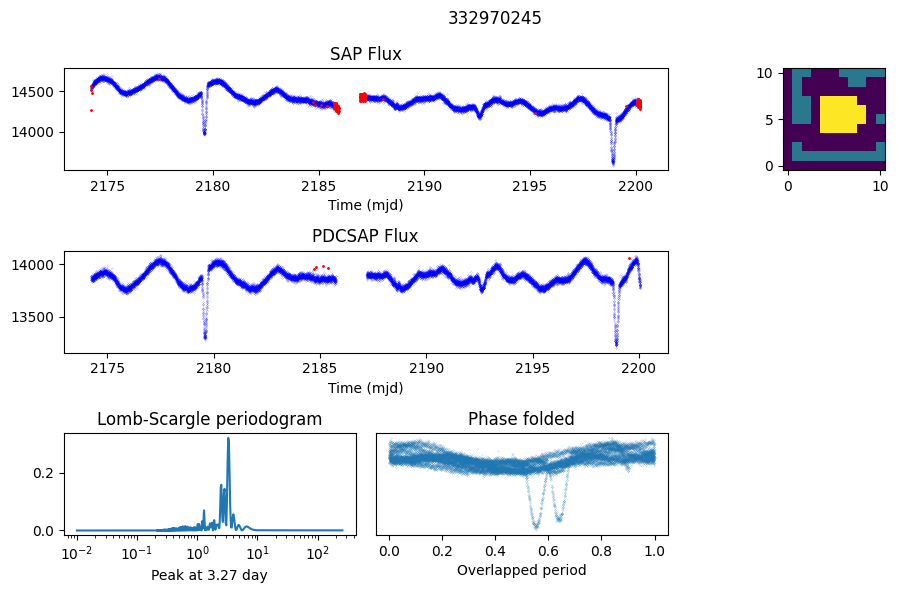

In [11]:
for i in range(len(table)):
    megazord(table["Time"][i], table["PDC_F"][i],table["SAP_F"][i], table["Flag"][i], table["Power"][i], table["Frequency"][i],table["Phase"][i], table["Image"][i], table["ID"][i])


In [14]:
x=cross_TESS["Period(d)"]
y=cross_TESS["L_8_Avg"]

Text(0, 0.5, 'L_x')

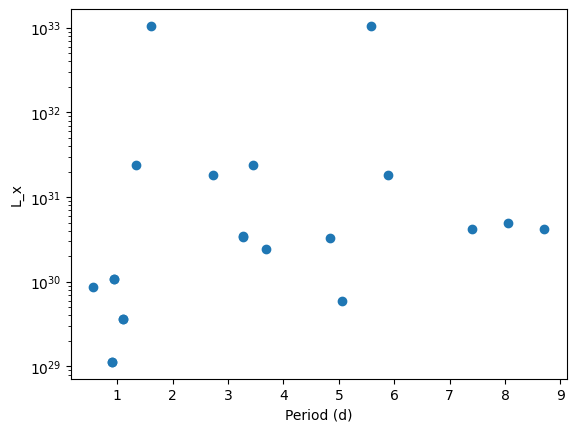

In [24]:
plt.scatter(x,y)
plt.yscale('log')
plt.xlabel("Period (d)")
plt.ylabel("L_x")

In [ ]:
#Analyse des LC et de leurs variations